In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
from torchsummary import summary

import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

data_path = "C:/Users/arwin/Documents/dev/APS360-PROJECT/data"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [1]:

class BigModel(nn.Module):
  def  __init__(self):
    super(BigModel, self).__init__()
    # CNN
    resnet18 = models.resnet18(pretrained=True)
    self.features = nn.Sequential(*(list(resnet18.children())[:-2])) # I removed the last two layers of resnet and replaced them with the ones said in the paper
    self.features.add_module("pool", nn.AdaptiveMaxPool2d((1,1)))

    self.fc1_cnn = nn.Linear(512, 256)
    self.dropout_cnn = nn.Dropout(p = 0.5)
    self.batch_norm_cnn = nn.BatchNorm1d(256)
    
    # RNN
    self.bi_gru = nn.GRU(input_size=672, hidden_size = 256, num_layers =1, batch_first=True, bidirectional=True) # I dont know what the size of the input to the bi-gru is supposed to be
    self.fc_gru = nn.Linear(512, 256)
    
    # FC LAYERS
    self.dropout = nn.Dropout(p = 0.5)
    # self.fc = nn.Linear(512, 1)
    self.fc = nn.Linear(512, 10) # becuase 10 genre classes
    # self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    # CNN
    # print(f"Shape before ResNet features: {x.shape}")  # Debug statement 1
    x1 = self.features(x)
    # print(f"Shape after ResNet features: {x1.shape}")  # Debug statement 1
    x1 = torch.flatten(x1, 1)
    # print(f"Shape after flattening: {x1.shape}")  # Debug statement 2
    x1 = self.fc1_cnn(x1)
    x1 = self.dropout_cnn(x1)
    x1 = self.batch_norm_cnn(x1)
    
    # Bi-GRU
    batch_size, channels, height, width = x.shape
    x2 = x.view(batch_size, height, -1)
    # print(f"Shape before Bi-GRU: {x2.shape}")  # Debug statement 4
    x2, _ = self.bi_gru(x2)
    x2 = torch.cat((x2[:, -1, :256], x2[:, 0, 256:]), dim=1)
    x2 = self.fc_gru(x2)

    # Concat Outputs of each model
    x = torch.cat((x1, x2), -1)
    x = self.dropout(x)
    x = self.fc(x)
    # x = self.sigmoid(x)
    return x

class CustomImageDataset(Dataset):
  def __init__(self, img_dirs, transform=None):
      """
      Args:
          img_dirs (dict): Dictionary with keys 'hit' and 'miss' and their respective image directory paths.
          transform (callable, optional): Optional transform to be applied on a sample.
      """
      self.img_labels = []
      self.img_files = []
      for label, dir_path in img_dirs.items():
          for file in os.listdir(dir_path):
              if file.endswith('.png'):
                  self.img_files.append(os.path.join(dir_path, file))
                  self.img_labels.append(1 if label=='hit' else 0)
      self.transform = transform

  def __len__(self):
      return len(self.img_files)

  def __getitem__(self, idx):
      img_path = self.img_files[idx]
      image = Image.open(img_path).convert('RGB')
      label = self.img_labels[idx]
      if self.transform:
          image = self.transform(image)
      return image, torch.tensor(label, dtype=torch.float) 

def get_model_name(batch_size, learning_rate, epoch, weight_decay):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "transfermodel_bs{0}_lr{1}_epoch{2}_wd{3}".format(
                                                   batch_size,
                                                   learning_rate,
                                                   epoch,
                                                   weight_decay)
    return path

def modify_model_for_binary_classification(model):
    # Freeze feature layers
    for param in model.features.parameters():
        param.requires_grad = False
    for param in model.bi_gru.parameters():
        param.requires_grad = False
    # for param in model.fc1_cnn.parameters():
    #     param.requires_grad = False
    # for param in model.fc_gru.parameters():
    #     param.requires_grad = False
    # for param in model.batch_norm_cnn.parameters():
    #     param.requires_grad = False
    
    # Remove and add new FC layers for binary classification
    # Adjust the input features of the first linear layer according to your new architecture
    model.fc = nn.Sequential(
        nn.Linear(512, 256),  # Adjust the input size if needed
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(256, 1),
        nn.Sigmoid()
    )

    return model

# Accuracy calculation function
def binary_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

transform = transforms.Compose([
    # transforms.Resize((224, 224)),  
    transforms.ToTensor(),
])
img_dirs = {
    'hit': data_path + '/billboard_spec',
    'miss': data_path + '/random_spec'
}

# Initialize your dataset
dataset = CustomImageDataset(img_dirs=img_dirs, transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size + test_size])
val_dataset, test_dataset = torch.utils.data.random_split(val_test_dataset, [val_size, test_size])

len(val_dataset), len(test_dataset)

NameError: name 'nn' is not defined

In [21]:
def eval_model(model_path, criterion, data_loader):
    model = BigModel()
    model = modify_model_for_binary_classification(model)
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)  # Adjust for label dimensions

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            acc = binary_accuracy(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += acc.item() * inputs.size(0)

    loss = running_loss / len(data_loader.dataset)
    acc = running_corrects / len(data_loader.dataset)

    return acc

In [39]:
def eval_model_with_precision_recall(model_path, criterion, data_loader):
    model = BigModel()
    model = modify_model_for_binary_classification(model)
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0
    TP = 0  # True Positives
    FP = 0  # False Positives
    FN = 0  # False Negatives

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)  # Adjust for label dimensions

            outputs = model(inputs)
            preds = torch.round(outputs)
            loss = criterion(outputs, labels)
            acc = binary_accuracy(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += acc.item() * inputs.size(0)

            # Update TP, FP, FN
            TP += ((preds == 1) & (labels == 1)).sum().item()
            FP += ((preds == 1) & (labels == 0)).sum().item()
            FN += ((preds == 0) & (labels == 1)).sum().item()

    loss = running_loss / len(data_loader.dataset)
    acc = running_corrects / len(data_loader.dataset)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    return acc, precision, recall


In [43]:
# model 1

batchsz = 128
lr = 0.0005
epoch= 75
wd = 0

model_name = get_model_name(batchsz, lr, epoch, wd)
model_path = f"../transfer_learning/{model_name}/{model_name}.pth"
os.path.exists(f"../transfer_learning/{model_name}/{model_name}.pth")

val_loader = DataLoader(val_dataset, batch_size=batchsz, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=batchsz, shuffle=True)

criterion = nn.BCELoss()

acc, prec, rec = eval_model_with_precision_recall(model_path, criterion, test_loader)
print(f"model 1. acc = {acc}, prec = {prec}, rec = {rec}")
# model 2
batchsz = 512
lr = 0.001
epoch= 100
wd = 0

model_name = get_model_name(batchsz, lr, epoch, wd)
model_path = f"../transfer_learning/{model_name}/{model_name}.pth"
os.path.exists(f"../transfer_learning/{model_name}/{model_name}.pth")

val_loader = DataLoader(val_dataset, batch_size=batchsz, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=batchsz, shuffle=True)

criterion = nn.BCELoss()

acc, prec, rec = eval_model_with_precision_recall(model_path, criterion, test_loader)
print(f"model 2. acc = {acc}, prec = {prec}, rec = {rec}")



model 1. acc = 0.7640966641340486, prec = 0.7214953271028037, rec = 0.8733031674208145
model 2. acc = 0.7813578882480793, prec = 0.7625, rec = 0.8280542986425339


In [35]:
for i in range(10):
    # get randomized data sets
    train_dataset, val_test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size + test_size])
    val_dataset, test_dataset = torch.utils.data.random_split(val_test_dataset, [val_size, test_size])


    # model 1

    batchsz = 128
    lr = 0.0005
    epoch= 75
    wd = 0

    model_name = get_model_name(batchsz, lr, epoch, wd)
    model_path = f"../transfer_learning/{model_name}/{model_name}.pth"
    os.path.exists(f"../transfer_learning/{model_name}/{model_name}.pth")

    val_loader = DataLoader(val_dataset, batch_size=batchsz, shuffle=True) 
    test_loader = DataLoader(test_dataset, batch_size=batchsz, shuffle=True)

    criterion = nn.BCELoss()

    model_1_acc = eval_model(model_path, criterion, test_loader)

    # model 2
    batchsz = 512
    lr = 0.001
    epoch= 100
    wd = 0

    model_name = get_model_name(batchsz, lr, epoch, wd)
    model_path = f"../transfer_learning/{model_name}/{model_name}.pth"
    os.path.exists(f"../transfer_learning/{model_name}/{model_name}.pth")

    val_loader = DataLoader(val_dataset, batch_size=batchsz, shuffle=True) 
    test_loader = DataLoader(test_dataset, batch_size=batchsz, shuffle=True)

    criterion = nn.BCELoss()

    model_2_acc = eval_model(model_path, criterion, test_loader)

    print(f"Model 1 Acc: {model_1_acc}, Model 2 Acc: {model_2_acc}, Higher: {'Model 1' if model_1_acc > model_2_acc else 'Model 2'}")

Model 1 Acc: 0.8020713459636043, Model 2 Acc: 0.8124280827777981, Higher: Model 2
Model 1 Acc: 0.7790563855538846, Model 2 Acc: 0.7710011558236406, Higher: Model 1
Model 1 Acc: 0.7963176050038003, Model 2 Acc: 0.7836593840146915, Higher: Model 1
Model 1 Acc: 0.7790563820557984, Model 2 Acc: 0.796317611657023, Higher: Model 2
Model 1 Acc: 0.7813578822121658, Model 2 Acc: 0.7905638719318376, Higher: Model 2
Model 1 Acc: 0.7997698506771215, Model 2 Acc: 0.7928653682471694, Higher: Model 1
Model 1 Acc: 0.8009205990062621, Model 2 Acc: 0.7905638720004275, Higher: Model 1
Model 1 Acc: 0.7756041446818581, Model 2 Acc: 0.7882623750677866, Higher: Model 2
Model 1 Acc: 0.8078250858945594, Model 2 Acc: 0.7986191073550454, Higher: Model 1
Model 1 Acc: 0.764096658235315, Model 2 Acc: 0.78135788763077, Higher: Model 2


In [24]:
def plot_model(history_path):
    # Load the saved training history

    data = np.load(history_path)

    # Extracting the training and validation losses and accuracies
    train_losses = data['train_losses']
    val_losses = data['val_losses']
    train_accuracies = data['train_accuracies']
    val_accuracies = data['val_accuracies']

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    # Plot training and validation losses

    # Example for setting text size individually
    axs[0].set_xlabel('Epochs', fontsize=20)  # Adjust fontsize as needed
    axs[0].set_ylabel('Loss', fontsize=20)  # Adjust fontsize as needed
    axs[0].set_title(f'Training and Validation Loss for {model_name}', fontsize=16)  # Adjust fontsize as needed
    axs[0].legend(fontsize=20)
    axs[0].set_xlim(0, len(train_losses))  # Set x-axis range from 0 to number of epochs
    # axs[0].set_ylim(0, max(max(train_losses), max(val_losses)))  # Set y-axis range

    # And similarly for other text elements

    axs[0].plot(train_losses, label='Training Loss')
    axs[0].plot(val_losses, label='Validation Loss')



    # Plot training and validation accuracies
    axs[1].plot(train_accuracies, label='Training Accuracy')
    axs[1].plot(val_accuracies, label='Validation Accuracy')
    axs[1].set_xlabel('Epochs', fontsize=20)
    axs[1].set_ylabel('Accuracy', fontsize=20)
    axs[1].set_title(f'Training and Validation Accuracy for {model_name}',fontsize=16)
    axs[1].legend()
    axs[1].set_xlim(0, len(train_accuracies))  # Set x-axis range from 0 to number of epochs
    # axs[1].set_ylim(0, 1)  # Assuming accuracy ranges from 0 to 1

    plt.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


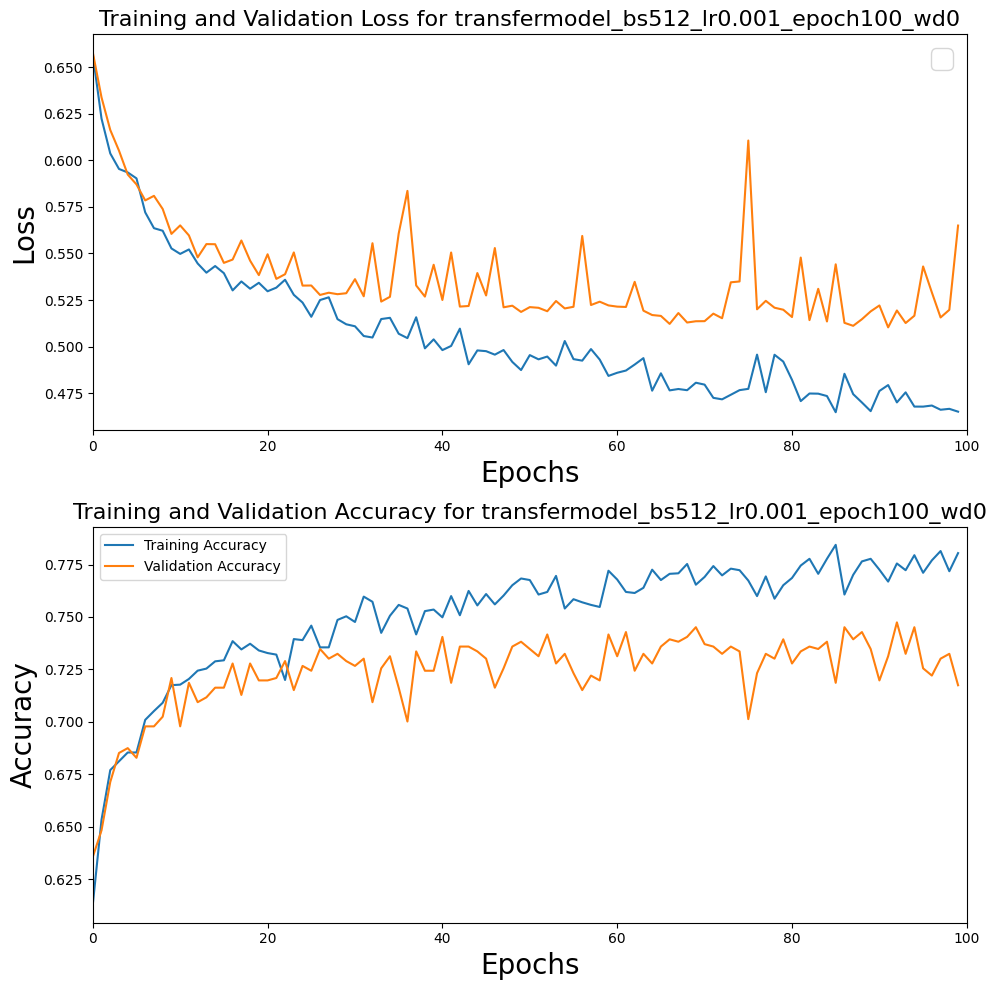

In [37]:
plot_model('C:/Users/arwin/Documents/dev/APS360-PROJECT/transfer_learning/transfermodel_bs512_lr0.001_epoch100_wd0.001/transfermodel_bs512_lr0.001_epoch100_wd0.001.npz')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


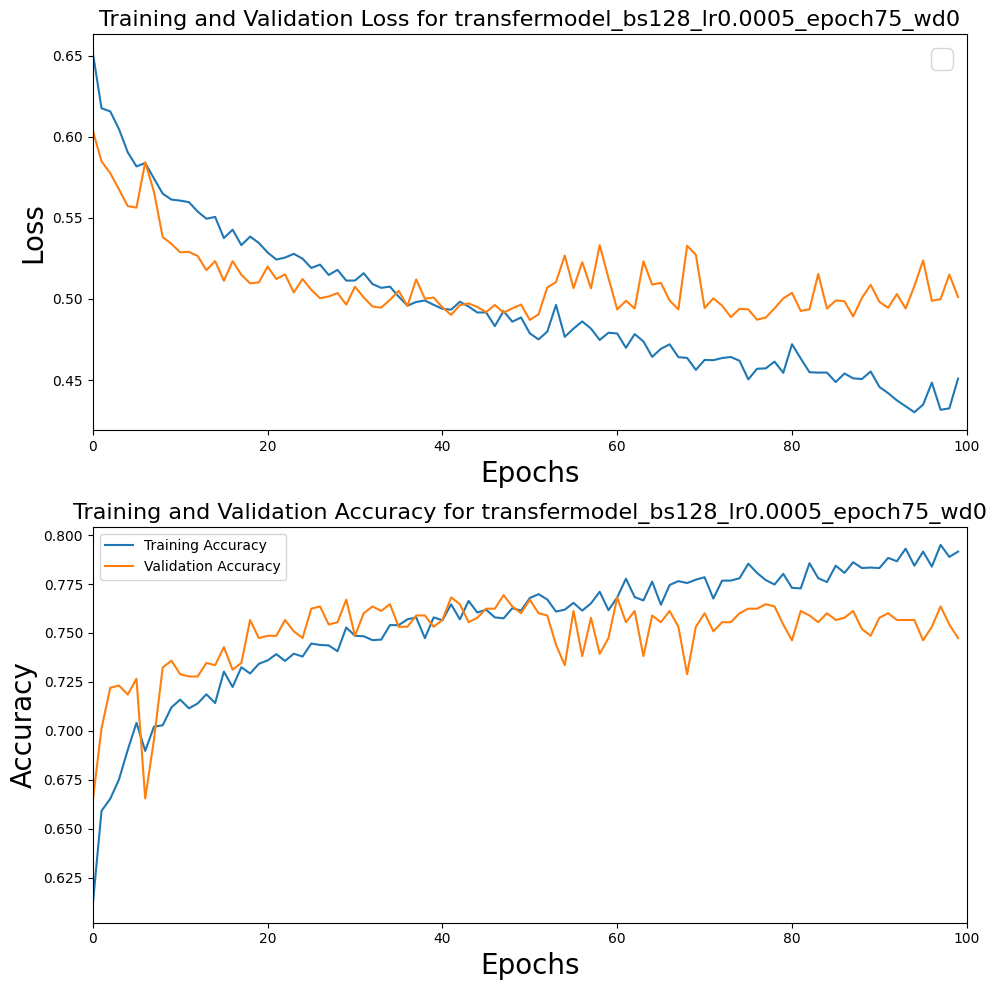

In [28]:
plot_model('C:/Users/arwin/Documents/dev/APS360-PROJECT/transfer_learning/transfermodel_bs512_lr0.001_epoch100_wd0/transfermodel_bs512_lr0.001_epoch100_wd0.npz')
